# Project Idea 1: 

- Make a simplifying assumption between the **loan issuance date** and application dates,
convert the approved loans into the formats of rejected loan applications.
- Use supervised technique and clustering, describe (reverse engineering) 
the loan approval criterion of **Lending Club**.

    - Challenges: The aggregated data has more than $20M$ samples. This is
        beyond the coverage of many ML algorithms. How do you design an apporach 
        which allows you to train on such a large size data? The problem is
        particularly serious for training **pooled** models.
    - When you apply supervised technique, it might involve imbalanced classification.
    How would you handle 'im-balanced dataset' like this?
    
- Are there poor performing approved loans which should be rejected?
- What is the business impact (pros and cons) of rejecting such non-performing loans?
</a><br>
# Structure: 
- <a href="#preprocessing">Preprocessing</a><br>
- <a href="#function">Function</a><br>
- <a href="#ml">Machine Learning</a><br>
    - Unsupervised Machine Learning  
        - <a href="#kmeans">K Means</a><br> 

    - Supervised Machine Learning      
        - <a href="#decision">Decision Tree</a><br>
        - <a href="#rf">Random Forest</a><br>
        - <a href="#svm">SVM</a><br>
        - <a href="#xgboost">XGBoost</a><br>
        - <a href="#logistic">Logistic Regression</a><br>
        - <a href="#naive">Naive Bayes Classifier</a><br>
        - <a href="#neighbor">Nearest Neighbor</a><br>
- <a href="#imbalance">Handling Imbalanced Data</a><br>
    - <a href="#smote">SMOTE</a><br>

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression 
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 


In [3]:
df_raw_accepted = pd.read_csv('accepted_2007_to_2018Q4.csv.gz')
df_raw_rejected = pd.read_csv('rejected_2007_to_2018Q4.csv.gz')

C:\Users\Laptop2\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_raw_accepted.sample(frac=0.06,random_state=30).to_csv('sample_accepted.csv')
df_raw_rejected.sample(frac=0.06,random_state=30).to_csv('sample_rejected.csv')

In [10]:
print (df_raw_accepted.shape)
print (df_raw_rejected.shape)


(2260701, 151)
(27648741, 9)


In [11]:
sample_accepted = pd.read_csv('sample_accepted.csv')
sample_rejected = pd.read_csv('sample_rejected.csv')

In [12]:
sample_accepted.shape

(135642, 152)

In [25]:
def data_process(df_accepted,df_rejected):
    
    accepted = df_accepted.copy()
    rejected = df_rejected.copy()
    
    # Processing accepted data 
    accepted = accepted[['loan_amnt', 'purpose', 'dti',
       'addr_state', 'emp_length', 'issue_d',
       'loan_status', 'last_fico_range_high','last_fico_range_low']]
    
    accepted['issue_d'] = pd.to_datetime(accepted['issue_d'])
    accepted['app_year'] = accepted['issue_d'].dt.year
    accepted['app_month'] = accepted['issue_d'].dt.month

    accepted['risk_score'] = (accepted['last_fico_range_high'] + accepted['last_fico_range_low'])/2
    accepted = accepted.drop(columns = ['issue_d','last_fico_range_high','last_fico_range_low'])


    accepted['loan_status'] =1
            
    
    # Processing rejected data 
    rejected = rejected.iloc[:,1:9]
    rejected = rejected.rename(columns={"Amount Requested": "loan_amnt", "Application Date": "app_date", "Loan Title": "purpose",
                             "Risk_Score": "risk_score", "Debt-To-Income Ratio": "dti", "Zip Code": "zip_code",
                             "State": "addr_state", "Employment Length": "emp_length"})
    rejected['loan_status'] = 0
    
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*consolidation.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*loan.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*debt.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*card.*$)', 'credit_card')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*credit.*$)', 'credit_card')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*house.*$)', 'house')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*business.*$)', 'small_business')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*car.*$)', 'car')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*education.*$)', 'education')
    
    
    rejected['purpose'] = np.where(rejected['purpose'].isin(['house', 'credit_card', 'major_purchase', 'debt_consolidation',
       'other', 'moving', 'small_business', 'home_improvement',
       'vacation', 'medical', 'renewable_energy', 'car', 'wedding']), rejected['purpose'], 'other')

    rejected['app_date'] = pd.to_datetime(rejected['app_date'])
    rejected['app_year'] = rejected['app_date'].dt.year
    rejected['app_month'] = rejected['app_date'].dt.month

    rejected = rejected.drop(columns = 'app_date')
    rejected = rejected.drop(columns = 'zip_code')
    
    rejected['dti'] = rejected['dti'].str.replace('%','')
    
    # Merge accepted and rejected data for later process
    df_processed = pd.concat([accepted, rejected], sort=True)
    

    # Convert categorical to numerical-- 10 means more than 10 years 
    df_processed['emp_length'] = df_processed['emp_length'].str.extract('(\d+)')


    # Missing Values: risk_score, emp_length, dti
    df_processed['emp_length'] = df_processed['emp_length'].fillna(0)
    df_processed['emp_length'] = df_processed['emp_length'].astype(int)
    df_processed['risk_score'] = df_processed['risk_score'].fillna(0)
    df_processed['dti'] = df_processed['dti'].fillna(0)
    df_processed['dti'] = df_processed['dti'].astype(float)
    df_processed = df_processed.dropna()

    df_processed = pd.get_dummies(df_processed)

    return df_processed

In [26]:
df_processed = data_process(sample_accepted,sample_rejected)

In [27]:
df_processed.shape

(1794562, 72)

In [28]:
from sklearn.model_selection import train_test_split

df_processed = data_process(sample_accepted,sample_rejected)
# The predicted column is "loan_status" , split the data into training and test sets.
x_m = df_processed.drop(['loan_status'], axis=1)
y_m = df_processed.loc[:,'loan_status']
X_train, X_test, y_train, y_test = train_test_split(x_m, y_m, test_size=0.2, random_state=42)

 <p><a name="ml"></a></p>
 
 # Machine Learning
 
- Supervised Machine Learning      
    - <a href="#rf">Random Forest-Class Weight Balanced
    - <a href="#logistic">Logistic Regression-Class Weight Balanced</a><br>
</a><br>
</a><br>
- Links: 
    - https://github.com/perryrjohnson/Walk-Score/blob/master/feature%20engineering.ipynb
    - https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [19]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score


from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score, roc_curve
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

## Random Forest unbalanced

In [52]:

from sklearn.ensemble import RandomForestClassifier

# Create the model with 1000 trees
rand = RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=-1)

# Fit on training data
rand.fit(X_train, y_train)
y_pred_rand = rand.predict(X_test)

print(f'Model Accuracy: {rand.score(X_train, y_train)}')
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_rand))


Model Accuracy: 0.9685730982990968
Test Accuracy: 0.9684909713496028


[[330300   1500]
 [  9809  17304]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    331800
           1       0.92      0.64      0.75     27113

    accuracy                           0.97    358913
   macro avg       0.95      0.82      0.87    358913
weighted avg       0.97      0.97      0.97    358913



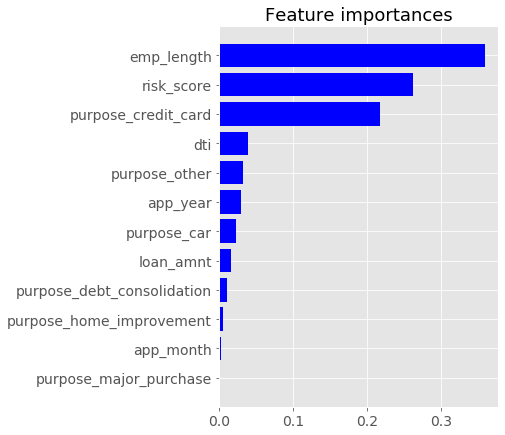

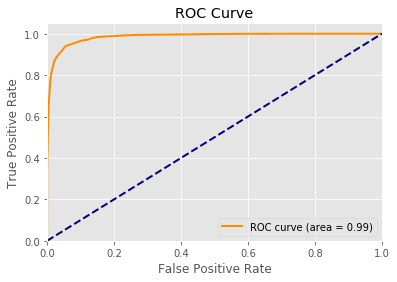

In [53]:

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_rand)
print(confusion_matrix)
print(classification_report(y_test, y_pred_rand))

# Actual class predictions
rf_predictions = rand.predict(X_test)
# Probabilities for each class
rf_probs = rand.predict_proba(X_test)[:, 1]

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

#feature importance
features = X_train.columns
importance = rand.feature_importances_

indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);

plt.show()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

y_predict_probabilities = rand.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [54]:
#feature importance
features = X_train.columns
rand_importance=list(rand.feature_importances_)
rand_Top_15_feature=pd.DataFrame(list(zip(features,rand_importance)),columns=['Feature','Importance']).sort_values(by='Importance',ascending=False).head(12)
rand_Top_15_feature

,Feature,Importance
3,emp_length,0.358517
5,risk_score,0.261619
58,purpose_credit_card,0.217457
2,dti,0.039092
66,purpose_other,0.032449
1,app_year,0.029865
57,purpose_car,0.022533
4,loan_amnt,0.015643
59,purpose_debt_consolidation,0.010651
61,purpose_home_improvement,0.005532


### Random Forest Balanced - class_weight="balanced"

Model Accuracy: 0.9531138878653487
Test Accuracy: 0.9527294915480911
[[316280  15520]
 [  1446  25667]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    331800
           1       0.62      0.95      0.75     27113

    accuracy                           0.95    358913
   macro avg       0.81      0.95      0.86    358913
weighted avg       0.97      0.95      0.96    358913



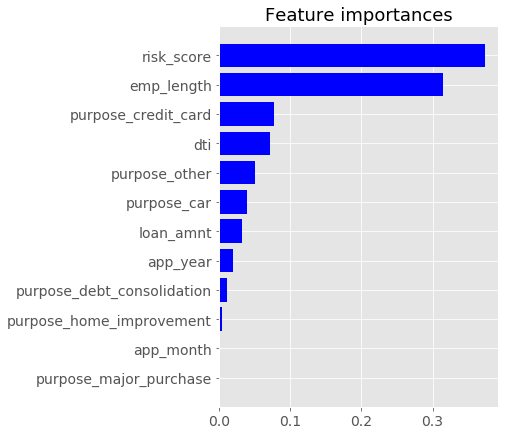

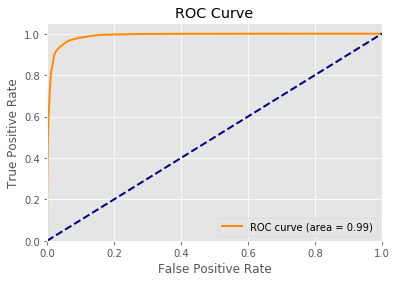

In [55]:

from sklearn.ensemble import RandomForestClassifier

# Create the model with 1000 trees
rand = RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=-1,class_weight="balanced")

# Fit on training data
rand.fit(X_train, y_train)
y_pred_rand = rand.predict(X_test)

print(f'Model Accuracy: {rand.score(X_train, y_train)}')
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_rand))


from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_rand)
print(confusion_matrix)
print(classification_report(y_test, y_pred_rand))

# Actual class predictions
rf_predictions = rand.predict(X_test)
# Probabilities for each class
rf_probs = rand.predict_proba(X_test)[:, 1]

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

#feature importance
features = X_train.columns
importance = rand.feature_importances_

indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);

plt.show()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

y_predict_probabilities = rand.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()




In [56]:
#feature importance
features = X_train.columns
rand_importance=list(rand.feature_importances_)
rand_Top_15_feature=pd.DataFrame(list(zip(features,rand_importance)),columns=['Feature','Importance']).sort_values(by='Importance',ascending=False).head(12)
rand_Top_15_feature



,Feature,Importance
5,risk_score,0.373265
3,emp_length,0.314914
58,purpose_credit_card,0.077849
2,dti,0.070838
66,purpose_other,0.050314
57,purpose_car,0.039887
4,loan_amnt,0.032026
1,app_year,0.019899
59,purpose_debt_consolidation,0.010784
61,purpose_home_improvement,0.004550


 <p><a name="logistic"></a></p>
 
 ### Logistic Regression--unbalanced
 
- Links: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

C:\Users\Laptop2\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of logistic regression classifier on test set: 0.95
[[327446   4354]
 [ 13355  13758]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    331800
           1       0.76      0.51      0.61     27113

    accuracy                           0.95    358913
   macro avg       0.86      0.75      0.79    358913
weighted avg       0.95      0.95      0.95    358913



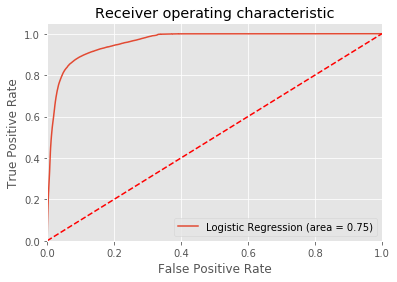

In [57]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, logreg.predict(X_test))

print(confusion_matrix)

print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


<BarContainer object of 12 artists>

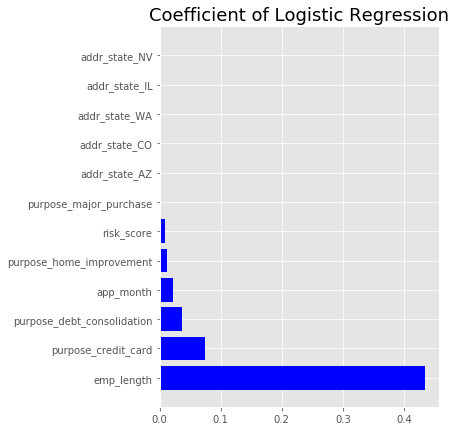

In [58]:
logistic_coef=logreg.coef_

logistic_coef_list=list(logistic_coef[0])
logistic_feature=X_train.columns.to_list()
Top_15_feature=pd.DataFrame(list(zip(logistic_feature,logistic_coef_list)),columns=['Features','Importance']).sort_values(by='Importance',ascending=False).head(12)


plt.figure(figsize=(5, 7))
plt.title("Coefficient of Logistic Regression", fontsize = 18)
plt.barh(Top_15_feature['Features'], Top_15_feature['Importance'], color="b",  align="center")


In [59]:
Top_15_feature

,Features,Importance
3,emp_length,0.435040
58,purpose_credit_card,0.074198
59,purpose_debt_consolidation,0.036508
0,app_month,0.021578
61,purpose_home_improvement,0.012260
5,risk_score,0.008716
63,purpose_major_purchase,0.002472
9,addr_state_AZ,0.001430
11,addr_state_CO,0.000985
53,addr_state_WA,0.000914


### Logistic regression balanced

Accuracy of logistic regression classifier on test set: 0.86
[[285160  46640]
 [  2293  24820]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92    331800
           1       0.35      0.92      0.50     27113

    accuracy                           0.86    358913
   macro avg       0.67      0.89      0.71    358913
weighted avg       0.94      0.86      0.89    358913



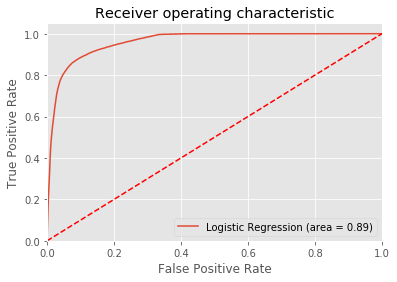

In [60]:
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, logreg.predict(X_test))

print(confusion_matrix)

print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


<BarContainer object of 12 artists>

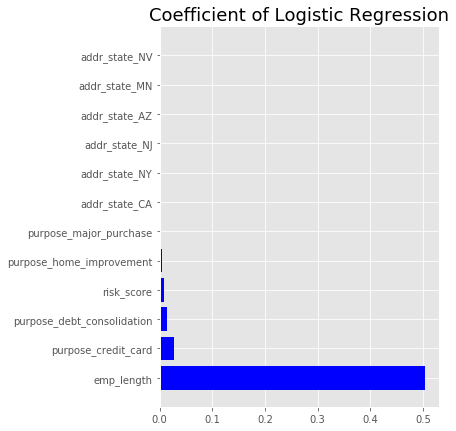

In [61]:
logistic_coef=logreg.coef_

logistic_coef_list=list(logistic_coef[0])
logistic_feature=X_train.columns.to_list()
Top_15_feature=pd.DataFrame(list(zip(logistic_feature,logistic_coef_list)),columns=['Features','Importance']).sort_values(by='Importance',ascending=False).head(12)


plt.figure(figsize=(5, 7))
plt.title("Coefficient of Logistic Regression", fontsize = 18)
plt.barh(Top_15_feature['Features'], Top_15_feature['Importance'], color="b",  align="center")
